# Structure recovery

### Part 1

In [1]:
import os
import sys

import pandas as pd
from rdkit.Chem import Draw

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "test_db"))

from connect import search_compounds

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# SQL expression
sql = """SELECT CM.CM_UNITS.CMU_REGID,QUATTRO_CR.BATCH.BATCH_REGID,
QUATTRO_CR.MOLECULE.MOL_REGID,QUATTRO_CR.MOLECULE.MOL_CTFILE
FROM CM.CM_UNITS,QUATTRO_CR.BATCH,QUATTRO_CR.MOLECULE
WHERE CM.CM_UNITS.CMA_ID = QUATTRO_CR.BATCH.BATCH_ID
AND QUATTRO_CR.BATCH.MOL_COMP_ID = QUATTRO_CR.MOLECULE.MOL_COMP_ID
AND QUATTRO_CR.BATCH.BATCH_REGID = :mybv"""

In [5]:
# get compounds
df = pd.read_excel("../data/raw/YTHDF2_Pilotscreen_hits.xlsx")
df.shape

(44, 36)

In [6]:
result = search_compounds(df["Batch ID"], sql=sql)
result.head(2)

Processed: 100%|██████████| 44/44 [00:00<00:00, 1206.95it/s]


,CMU_REGID,BATCH_REGID,MOL_REGID,ROMol
0,186128:01:01,186128:01,186128,<rdkit.Chem.rdchem.Mol object at 0x7d996e9accf0>
1,125620:01:01,125620:01,125620,<rdkit.Chem.rdchem.Mol object at 0x7d996e9ad4d0>


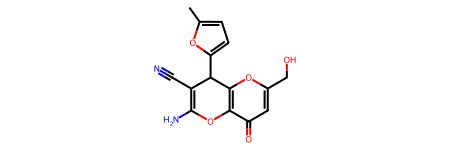

In [7]:
result.ROMol[0]

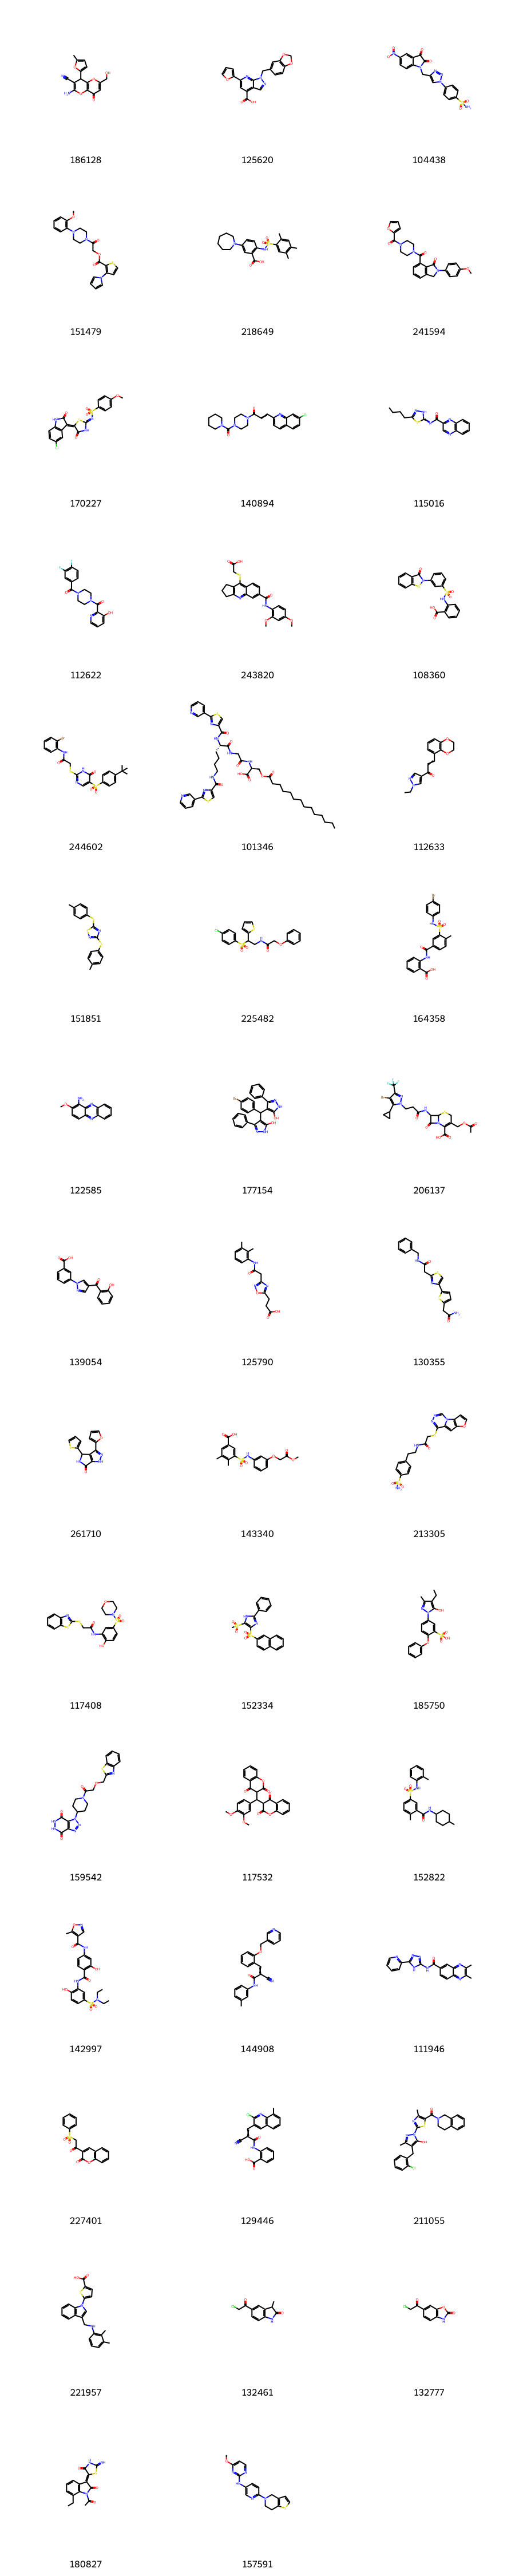

In [8]:
Draw.MolsToGridImage(result.ROMol.tolist(),
                     legends=result["MOL_REGID"].tolist(),
                     subImgSize=(300,300))

### Part 2

Now that it works, a larger test can be attempted.

In [9]:
# Read data from CPA (extracted using Pipeline Pilot web app)
df2 = pd.read_excel("/home/freddy/Documents/cp_datastore_meta.xlsx")

In [10]:
df2.drop(df2.query("Smiles == '*'").index, inplace=True)
df2.reset_index(inplace=True, drop=True)
df2 = df2.loc[:999, ["Compound_Id", "Well_Id", "Active"]]
df2.shape

(1000, 3)

In [11]:
df2.head()

,Compound_Id,Well_Id,Active
0,391012,391012:01:06_010.000_20h,True
1,393657,393657:01:02_010.000_20h,False
2,391425,391425:01:03_010.000_20h,False
3,393750,393750:01:02_010.000_20h,False
4,391642,391642:01:02_010.000_20h,False


In [12]:
# SQL expression
sql2 = """SELECT CM.CM_UNITS.CMU_REGID,QUATTRO_CR.BATCH.BATCH_REGID,
QUATTRO_CR.MOLECULE.MOL_REGID,QUATTRO_CR.MOLECULE.MOL_CTFILE
FROM CM.CM_UNITS,QUATTRO_CR.BATCH,QUATTRO_CR.MOLECULE
WHERE CM.CM_UNITS.CMA_ID = QUATTRO_CR.BATCH.BATCH_ID
AND QUATTRO_CR.BATCH.MOL_COMP_ID = QUATTRO_CR.MOLECULE.MOL_COMP_ID
AND QUATTRO_CR.MOLECULE.MOL_REGID = :mybv"""

In [13]:
import time

start = time.time()
result2 = search_compounds(df2["Compound_Id"], sql=sql2)
end = time.time()

print(f"Elapsed time: {end - start: .2f} s")

Processed:   0%|          | 0/1000 [00:00<?, ?it/s]

Processed: 100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]
[13:28:39] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 2 ignored.
[13:28:39] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 2 ignored.
[13:28:39] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 9 ignored.
[13:28:39] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 9 ignored.
[13:28:39] Skipping unrecognized collection type at line 92: MDLV30/HILITE ATOMS=(1 17)
[13:28:39] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 9 ignored.
[13:28:39] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 9 ignored.


Elapsed time:  220.55 s


In [14]:
result2.head()

,CMU_REGID,BATCH_REGID,MOL_REGID,ROMol
0,391012:01:01,391012:01,391012,<rdkit.Chem.rdchem.Mol object at 0x7d996e843a70>
1,393657:01:01,393657:01,393657,<rdkit.Chem.rdchem.Mol object at 0x7d996e842500>
2,391425:01:01,391425:01,391425,<rdkit.Chem.rdchem.Mol object at 0x7d996e843df0>
3,393750:01:01,393750:01,393750,<rdkit.Chem.rdchem.Mol object at 0x7d996e843d10>
4,391642:01:01,391642:01,391642,<rdkit.Chem.rdchem.Mol object at 0x7d996e843c30>


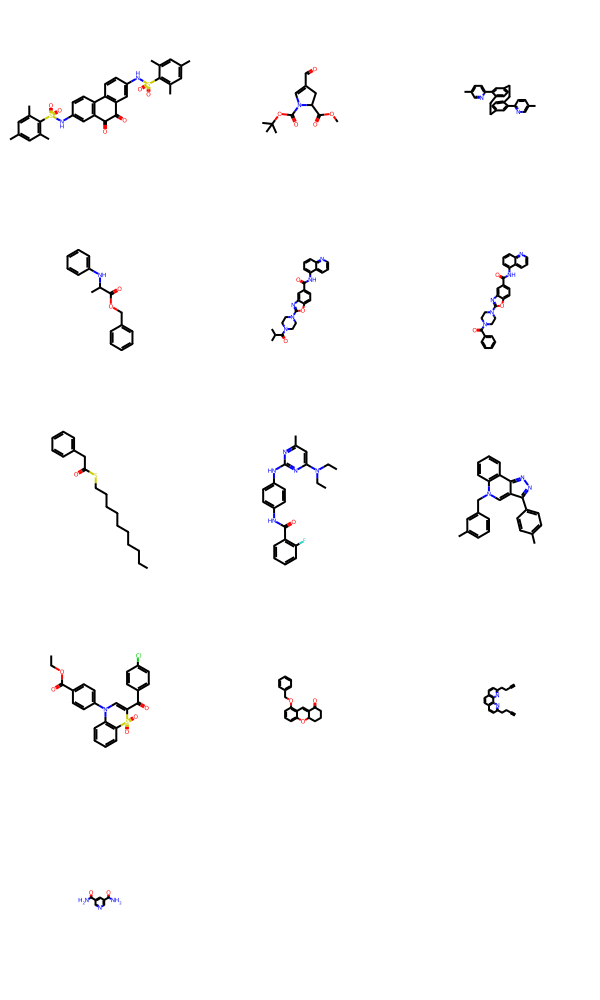

In [15]:
Draw.MolsToGridImage(result2.loc[:12, "ROMol"])

### Part 3

Now, I wanted to check if it's possible to catch the warnings that rdkit is outputing
for some molecules

In [19]:
from rdkit import Chem

m = Chem.MolFromSmiles('CN(C)(C)C', sanitize=False)
problems = Chem.DetectChemistryProblems(m)
print(problems[0].Message())

Explicit valence for atom # 1 N, 4, is greater than permitted


[16:57:53] Explicit valence for atom # 1 N, 4, is greater than permitted


In [ ]:
result3 = search_compounds(df["Batch ID"], sql=sql)
result3.head(2)

Compound:: 100%|██████████| 44/44 [00:00<00:00, 1185.34it/s]


,CMU_REGID,BATCH_REGID,MOL_REGID,MOL_CTFILE,ROMol,Problems
0,186128:01:01,186128:01,186128,\n INFOCHEM 2D 1 1.00000 0.000...,<rdkit.Chem.rdchem.Mol object at 0x71eccaf20660>,None
1,125620:01:01,125620:01,125620,\n INFOCHEM 2D 1 1.00000 0.000...,<rdkit.Chem.rdchem.Mol object at 0x71ecc9eba2d0>,None


In [38]:
result3.columns

Index(['CMU_REGID', 'BATCH_REGID', 'MOL_REGID', 'MOL_CTFILE'], dtype='object')

In [39]:
def detect_problems(mol):
    problems = Chem.DetectChemistryProblems(mol)
    if len(problems) != 0:
        return problems[0].Message()
    return None


def convert(ct):
    mol = Chem.MolFromMolBlock(ct)
    problems = detect_problems(mol)
    return mol, problems


In [41]:
convert(result3["MOL_CTFILE"][0])

(<rdkit.Chem.rdchem.Mol at 0x71eccaf82b90>, None)

In [61]:
more = []
for x in result3["MOL_CTFILE"]:
    more.append(convert(x))

result3[["1", "2"]] = more

In [ ]:
result4 = search_compounds(df2["Compound_Id"], sql=sql2)
result4.head(2)

Compound:: 100%|██████████| 1000/1000 [03:37<00:00,  4.59it/s]


,CMU_REGID,BATCH_REGID,MOL_REGID,MOL_CTFILE
0,391012:01:01,391012:01,391012,\n INFOCHEM 2D 1 1.00000 0.000...
1,393657:01:01,393657:01,393657,\n INFOCHEM 2D 1 1.00000 0.000...


In [72]:
result4.head()

,CMU_REGID,BATCH_REGID,MOL_REGID,MOL_CTFILE
0,391012:01:01,391012:01,391012,\n INFOCHEM 2D 1 1.00000 0.000...
1,393657:01:01,393657:01,393657,\n INFOCHEM 2D 1 1.00000 0.000...
2,391425:01:01,391425:01,391425,\n INFOCHEM 2D 1 1.00000 0.000...
3,393750:01:01,393750:01,393750,\n INFOCHEM 2D 1 1.00000 0.000...
4,391642:01:01,391642:01,391642,\n INFOCHEM 2D 1 1.00000 0.000...


In [77]:
Chem.MolToSmiles(result3.ROMol[0])

'CC1=CC=C(C2C(C#N)=C(N)OC3=C2OC(CO)=CC3=O)O1'

### Part 4